In [1]:
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifer
from aif360.algorithms.inprocessing.celisMeta.utils import getStats
from IPython.display import Markdown, display
import matplotlib.pyplot as plt


In [2]:
dataset_orig = load_preproc_data_adult()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


In [3]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)


#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

(1.0, 0.0)


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

([array([1.]), array([1.])], [array([0.]), array([0.])])


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [4]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)


#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

(1.0, 0.0)


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

([array([1.]), array([1.])], [array([0.]), array([0.])])


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [5]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())




min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
#display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.194402
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.194759
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.194402
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.194759


In [6]:
# Learn debiased classifier
tau = 0.8
debiased_model = MetaFairClassifer(tau=tau, sensitive_attr="race")
debiased_model.fit(dataset_orig_train)


('Training Accuracy: ', 0.7888209658077159, ', Training gamma: ', 0.8466343589061862)


In [7]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)


In [8]:
# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.226253
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.228184


In [9]:
display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.789463
Test set: Balanced classification accuracy = 0.707496
Test set: Disparate impact = 0.267508
Test set: Equal opportunity difference = -0.342941
Test set: Average odds difference = -0.232800
Test set: Theil_index = 0.147200


In [10]:
### Testing 
import numpy as np
import pandas as pd

predictions = list(dataset_debiasing_test.labels)
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["race"]

acc, sr, fdr = getStats(y_test, predictions, x_control_test)

# We give a 0.1 buffer since if the constraint might not be exactly satisfied if the 
# normal distribution is not a good fit for the training data.
assert fdr >= tau - 0.1

('Accuracy : ', 3085, 14653, 0.7894629086193954)
('SR tau : ', 0.6335828819141526)
('FPR tau : ', 0.6651902296035078)
('FNR tau : ', 0.9344431946006749)
('TPR tau : ', 0.9435242131376297)
('TNR tau : ', 0.9466027927717635)
('AR tau : ', 0.9175061708874659)
('FDR tau : ', 0.830043185477968)
('FOR tau : ', 0.5406237682301932)
('PPR tau : ', 0.8433187186542124)
('NPR tau : ', 0.924708780005249)


In [13]:
display(Markdown("#### Running the algorithm for different tau values"))

accuracies, false_discovery_rates, statistical_rates = [], [], []
s_attr = "race"
# Converting to form used by celisMeta.utils file
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)[s_attr]

all_tau = np.linspace(0.1, 0.9, 9)
for tau in all_tau:
    print("Tau: %.2f" % tau)
    debiased_model = MetaFairClassifer(tau=tau, sensitive_attr=s_attr)
    debiased_model.fit(dataset_orig_train)
    
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
    predictions = dataset_debiasing_test.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
    
    acc, sr, fdr = getStats(y_test, predictions, x_control_test)
    
    ## Testing if constraint is satisfied
    assert fdr >= tau - 0.1
    
    accuracies.append(acc)
    false_discovery_rates.append(fdr)
    statistical_rates.append(sr)
    

#### Running the algorithm for different tau values

Tau: 0.10
('Training Accuracy: ', 0.7076837579338384, ', Training gamma: ', 0.8515484318287467)
('Accuracy : ', 4268, 14653, 0.7087285880024569)
('SR tau : ', 0.7542862733882257)
('FPR tau : ', 0.8029785756264359)
('FNR tau : ', 0.907716535433071)
('TPR tau : ', 0.973575036075036)
('TNR tau : ', 0.9123443457370778)
('AR tau : ', 0.9475531524465962)
('FDR tau : ', 0.8186068256194482)
('FOR tau : ', 0.520823267948594)
('PPR tau : ', 0.7309292649098476)
('NPR tau : ', 0.9523649427495581)
Tau: 0.20
('Training Accuracy: ', 0.7143818187136213, ', Training gamma: ', 0.8740107239918714)
('Accuracy : ', 4167, 14653, 0.7156213744625675)
('SR tau : ', 0.6804186910415122)
('FPR tau : ', 0.7090519728192776)
('FNR tau : ', 0.7691338582677166)
('TPR tau : ', 0.9203232001159463)
('TNR tau : ', 0.8789558573886078)
('AR tau : ', 0.9233239855403916)
('FDR tau : ', 0.8362599159812782)
('FOR tau : ', 0.5883645137475918)
('PPR tau : ', 0.7659602999295992)
('NPR tau : ', 0.9585260144445069)
Tau: 0.30
('Train

### Plot of accuracy and output fairness vs input constraint (tau)

#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values.

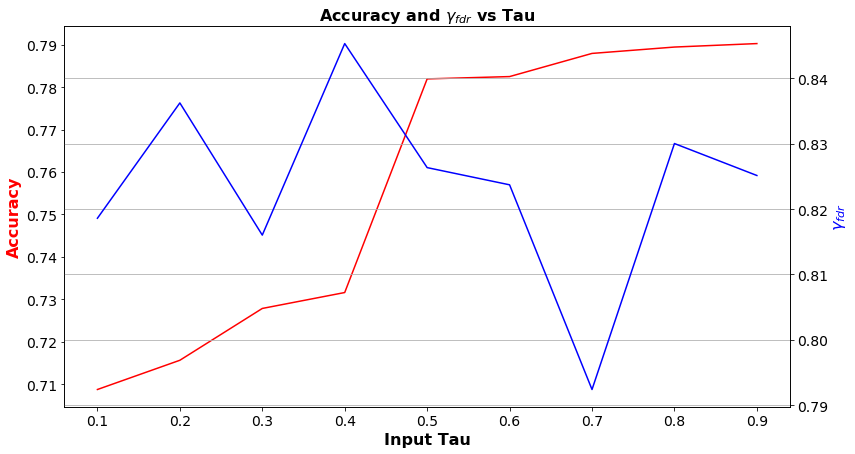

In [14]:
display(Markdown("### Plot of accuracy and output fairness vs input constraint (tau)"))

display(Markdown("#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values."))

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_tau, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{fdr}$ vs Tau', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input Tau', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_tau, false_discovery_rates, color='b')
ax2.set_ylabel('$\gamma_{fdr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


In [ ]:
# # 
#     References:
#         Celis, L. E., Huang, L., Keswani, V., & Vishnoi, N. K. (2018). 
#         "Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees.""
